## Explainable Evidential Clustering

In [131]:
folder_figures = 'figs/easy'

In [132]:
# imports
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from evclust.ecm import ecm
from lib.xedt import XEDT

In [133]:
# Load the csv file
df = pd.read_csv('data/easy_synth_data.csv')

feature_names = df.columns[:-1].to_list()
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
classes = np.unique(labels)

In [134]:
def plot_model(mass, F, model_name, lambda_num=1, cmap='Set1', legend=False):
    # cardinalities
    metacluster_cardinality = np.sum(F, axis=1)
    number_metaclusters = len(F)
    number_clusters = len(F[0])

    # bel and pl
    pl = np.matmul(mass, F)
    bel = mass[:, metacluster_cardinality == 1]
    
    # formatting focal sets for printing
    focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
    mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(number_clusters)]
    focal_sets = ['$'+f+'$' for f in focal_sets]

    # getting a proper colorscheme
    cmap = plt.get_cmap(cmap)
    if number_clusters == 3 and cmap.name == 'Pastel1':
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(0))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([1, 1, 1, 1])
    if number_clusters == 3 and cmap.name == 'Set1':
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(4))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([0.9, 0.9, 0.9, 1])
    else:
        cluster_base_colors = [np.array(cmap(i)) for i in range(len(F))]
        cardinality_indication_color = np.array(cmap(number_metaclusters))
    focal_colors = []
    for f in F:
        color = np.array([0., 0., 0., 0.])
        for i in range(len(f)):
            if f[i] == 1:
                color += cluster_base_colors[i]
        color = color/np.sum(f)

        color = color + (cardinality_indication_color - color) * (np.sum(f)-1)/(number_clusters-1)

        focal_colors.append(color)
    focal_colors[0] = cluster_base_colors[0]

    # getting centroids
    metacluster_centroids = []
    for i in range(len(F)):
        if np.sum(F[i]) > 0:
            centroid = np.zeros(features.shape[1])
            for point in range(features.shape[0]):
                centroid += features[point] * mass[point, i]
            centroid /= np.sum(mass[:, i])
            metacluster_centroids.append(centroid)
    metacluster_centroids = np.array(metacluster_centroids)

    # getting each point color
    colors = []
    diagrams = {}
    for point in range(len(features)):
        color = np.sum([focal_colors[i] * mass[point, i] for i in range(len(focal_sets))], axis=0)
        color = np.clip(color, 0, 1)
        color = color[:3]
        colors.append(color)

    # dark mode
    plt.style.use('dark_background')

    # plotting
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 3))
    for i in range(len(features)):
        ax[0].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
        ax2.scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
    for i in range(len(focal_sets)):
        ax[0].scatter([], [], color=focal_colors[i], label=focal_sets[i])
        ax2.scatter([], [], color=focal_colors[i], label=focal_sets[i])
    #ax.legend(loc='upper right')

    # plot centroids
    for i in range(len(metacluster_centroids)):
        ax[0].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='black', marker='*', s=200)
        ax2.scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='black', marker='*', s=200)

    ax[0].set_title(f"$\mathcal{{M}}_{{{model_name}}}$")
    ax2.set_title(f"$\mathcal{{M}}_{{{model_name}}}$")

    # remove ticks
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

    # export the fig2
    os.makedirs(f'{folder_figures}/xedt_outs_{model_name}', exist_ok=True)
    fig2.savefig(f'{folder_figures}/xedt_outs_{model_name}/data.pdf')

    figs = [fig2]
    axs = [ax2]

    # get the limits
    xmin, xmax = ax[0].get_xlim()
    ymin, ymax = ax[0].get_ylim()

    paths = {}
    idx_img = 1
    for lambda_mistakeness in [0, lambda_num, np.inf]:
        classifier = XEDT(lambda_mistakeness=lambda_mistakeness)

        y = mass.copy()
        classifier.fit(features, y, F)
        diagram = classifier.plot_tree(
            class_names = mass_focal_sets,
            focal_colors=focal_colors,
            cluster_names=focal_sets,
            feature_names=feature_names,
        )
        diagrams[lambda_mistakeness] = diagram

        path = classifier.get_path(['x','y'], focal_sets) # path is a dict
        paths[lambda_mistakeness] = path
        
        # create directory
        os.makedirs(f'{folder_figures}/xedt_outs_{model_name}', exist_ok=True)

        diagram.save(f'{folder_figures}/xedt_outs_{model_name}/diagram_{lambda_mistakeness}.pdf')

        X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
        features_xy = np.column_stack((X.ravel(), Y.ravel()))
        Z_metclus = classifier.predict_metacluster(features_xy).reshape(X.shape[0], X.shape[1], -1)

        Z_color = np.zeros((X.shape[0], X.shape[1], 3))
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z_color[i, j] = focal_colors[Z_metclus[i, j, 0]][:3]
        
        # for k in range(len(F)):
        #     for i in range(X.shape[0]):
        #         for j in range(X.shape[1]):
        #             Z_color[i, j] += Z_mass[i, j, k] * focal_colors[k][:3]

        fig2, ax2 = plt.subplots(1, 1, figsize=(5, 3))

        ax[idx_img].imshow(Z_color, extent=(xmin, xmax, ymin, ymax), origin='lower')#, aspect='auto')
        ax2.imshow(Z_color, extent=(xmin, xmax, ymin, ymax), origin='lower')#, aspect='auto')

        if lambda_mistakeness == np.inf:
            title = f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$'
        else:
            title = f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$'

        ax[idx_img].set_title(title)
        #ax2.set_title(title)

        ax[idx_img].set_xticks([])
        ax[idx_img].set_yticks([])

        ax2.set_xticks([])
        ax2.set_yticks([])
        
        # scatter the data
        for i in range(len(features)):
            ax[idx_img].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='white', linewidth=0.5)
            ax2.scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='white', linewidth=0.5)

        # plot centroids
        for i in range(len(metacluster_centroids)):
            ax[idx_img].scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='white', marker='*', s=200)
            ax2.scatter(metacluster_centroids[i, 0], metacluster_centroids[i, 1], color=focal_colors[i], edgecolor='white', marker='*', s=200)

        figs.append(fig2)
        axs.append(ax2)

        idx_img += 1

    if legend:
        lgd = fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='black', label=focal_sets[i], markerfacecolor=focal_colors[i], markersize=10) for i in range(len(focal_sets))]
                            ,edgecolor='black', loc='lower center', ncol=len(focal_sets), fontsize='large', title='meta-clusters ($F = 2^\Omega$)', bbox_to_anchor=(0.5, -0.15))
        
        plt.tight_layout()
        # export the figure
        fig.savefig(f'{folder_figures}/xedt_outs_{model_name}/plots.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

        k = 0
        for fig_ in figs:
            lgd = fig_.legend(handles=[plt.Line2D([0], [0], marker='o', color='black', label=focal_sets[i], markerfacecolor=focal_colors[i], markersize=10) for i in range(len(focal_sets))]
                                ,edgecolor='black', loc='lower center', ncol=len(focal_sets), fontsize='large', bbox_to_anchor=(0.5, -0.05))
            fig_.savefig(f'{folder_figures}/xedt_outs_{model_name}/data_{k}.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
            k += 1

    else:
        plt.tight_layout()
        # export the figure
        fig.savefig(f'{folder_figures}/xedt_outs_{model_name}/plots.pdf')

    # paths to df
    paths_df = pd.DataFrame()
    for lambda_mistakeness in paths.keys():
        path = paths[lambda_mistakeness]

        p = {}
        for d in path:
            for k, v in d.items():
                p.setdefault(k, []).append(v)

        df = pd.DataFrame(p)

        if lambda_mistakeness == np.inf:
            title = f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$'
        else:
            title = f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$'

        df.index = [title]

        paths_df = pd.concat([paths_df, df])        

    # paths_df export to latex
    paths_df.to_latex(f'{folder_figures}/xedt_outs_{model_name}/paths_table.tex', escape=False)

    display(paths_df)


    return paths_df

In [135]:
number_clusters = 2
model = ecm(x=features, c=number_clusters, beta = 1.3,  alpha=1, delta=3, disp=False)

,$\omega_{2}$,$\omega_{1} \cup \omega_{2}$,$\omega_{1}$
$M^{0}_{\mathcal{M}_{}}$,$(x \leq 2.69)$,$(x \leq 6.37) \wedge (x > 2.69)$,$(x > 6.37)$
$M^{0.01}_{\mathcal{M}_{}}$,$(x \leq 3.34)$,$(x \leq 6.03) \wedge (x > 3.34)$,$(x > 6.03)$
$M^\infty_{\mathcal{M}_{}}$,$(x \leq 3.88)$,$(x > 3.88) \wedge (x \leq 5.34)$,$(x > 5.34)$


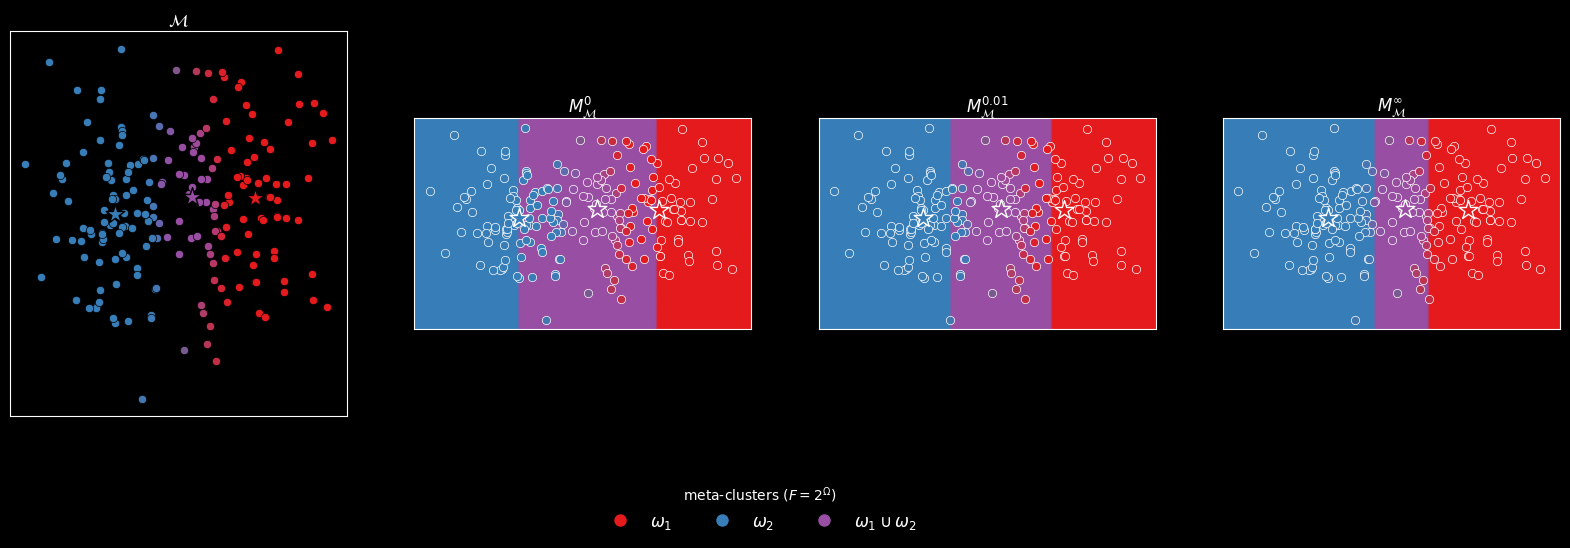

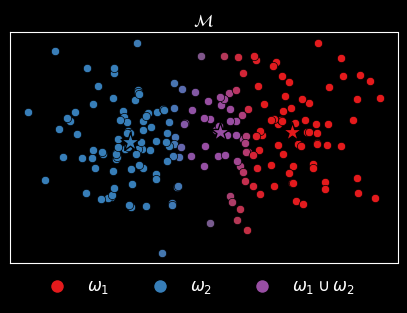

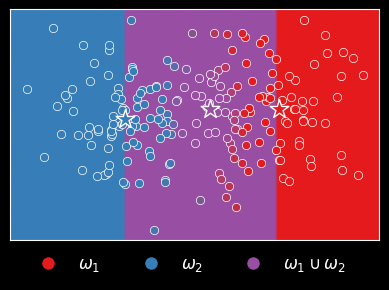

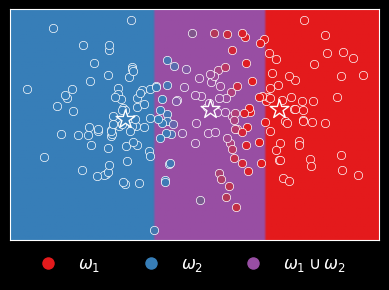

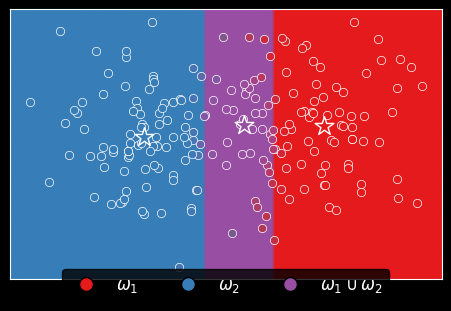

In [136]:
verysimple = plot_model(model['mass_n'], model['F'][1:], '', lambda_num=0.01, cmap='Set1', legend=True)